## 1. Import necessary libraries

In [22]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import joblib

import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2. Display Settings

In [23]:
pd.set_option("display.max_columns", None)

In [24]:
sklearn.set_config(transform_output="default")

## 3. Importing Dataset

In [25]:
train_df = pd.read_csv("data/train1.csv")
test_df = pd.read_csv("data/test1.csv")
val_df = pd.read_csv("data/val.csv")

In [26]:
def split_dataset(data):
	X = data.drop(columns="price")
	y = data.price.copy()
	return (X, y)

In [27]:
X_train, y_train = split_dataset(train_df)
print(X_train.info(), y_train.info())
X_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 640 entries, 0 to 639
Series name: price
Non-Null Count  Dtype
--------------  -----
640 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB
None None


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info


In [28]:
X_val , y_val = split_dataset(val_df)
print(X_val.info(), y_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          160 non-null    object 
 1   date_of_journey  160 non-null    object 
 2   source           160 non-null    object 
 3   destination      160 non-null    object 
 4   dep_time         160 non-null    object 
 5   arrival_time     160 non-null    object 
 6   duration         160 non-null    int64  
 7   total_stops      160 non-null    float64
 8   additional_info  160 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 11.4+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 160 entries, 0 to 159
Series name: price
Non-Null Count  Dtype
--------------  -----
160 non-null    int64
dtypes: int64(1)
memory usage: 1.4 KB
None None


In [29]:
X_test , y_test = split_dataset(test_df)
print(X_test.info(), y_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          200 non-null    object 
 1   date_of_journey  200 non-null    object 
 2   source           200 non-null    object 
 3   destination      200 non-null    object 
 4   dep_time         200 non-null    object 
 5   arrival_time     200 non-null    object 
 6   duration         200 non-null    int64  
 7   total_stops      200 non-null    float64
 8   additional_info  200 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 14.2+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 200 entries, 0 to 199
Series name: price
Non-Null Count  Dtype
--------------  -----
200 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB
None None


## 4. Data Pre-Processing

In [30]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]

num_cols = ["duration", "total_stops"]

cat_cols = ["airline","source","additional_info","destination"]

In [31]:
num_transformer =  Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler" , StandardScaler())
])

date_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

time_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour","minute"],format="mixed")),
    ("scaler", StandardScaler())

])



In [32]:
preprocessor = ColumnTransformer(transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols),
	("doj", date_transformer, ["date_of_journey"]),
	("time", time_transformer, ["dep_time", "arrival_time"])
])

In [33]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]], shape=(640, 33))

In [34]:
data = pd.concat([train_df,val_df],axis=0)

X_data , y_data = split_dataset(data)
print(X_data.shape , y_data.shape)

(800, 9) (800,)


## 5.Model Selection

In [35]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}

In [36]:
data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_dataset(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [37]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [38]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

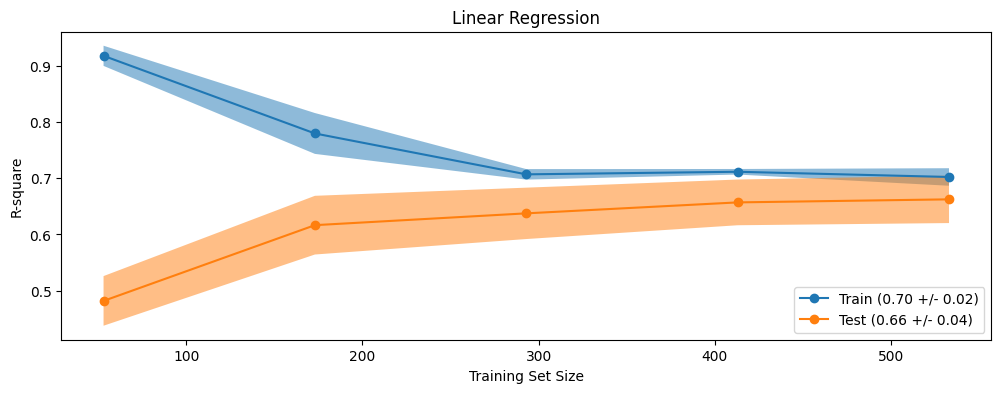

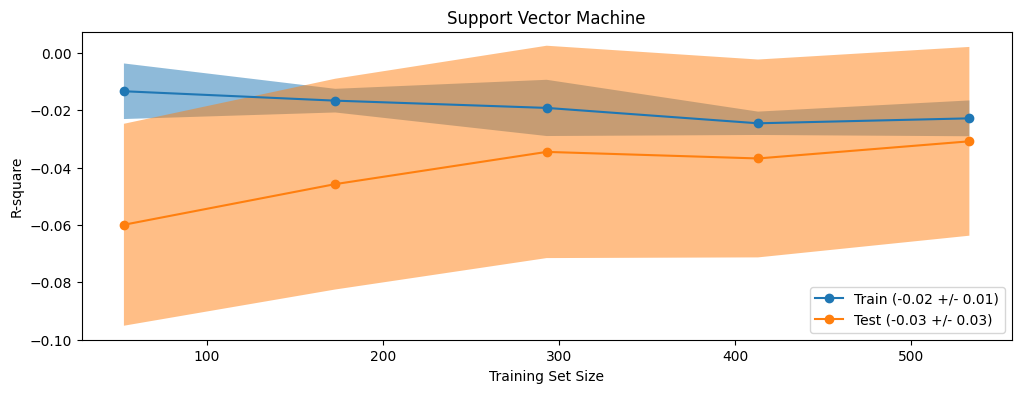

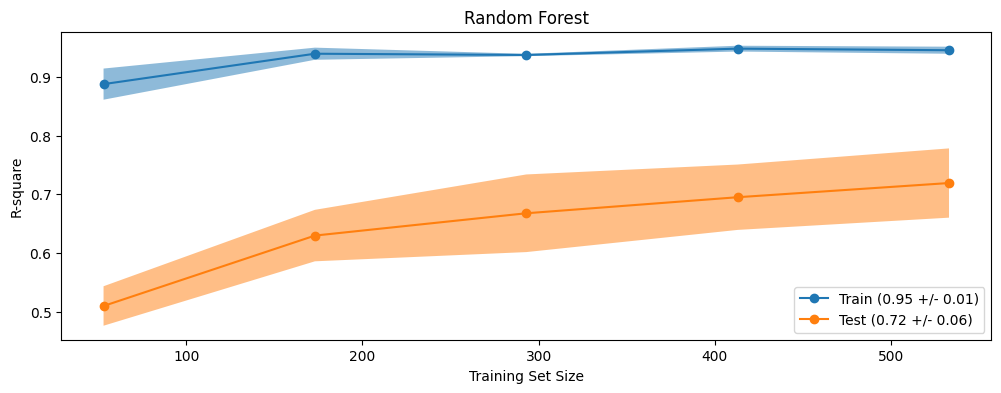

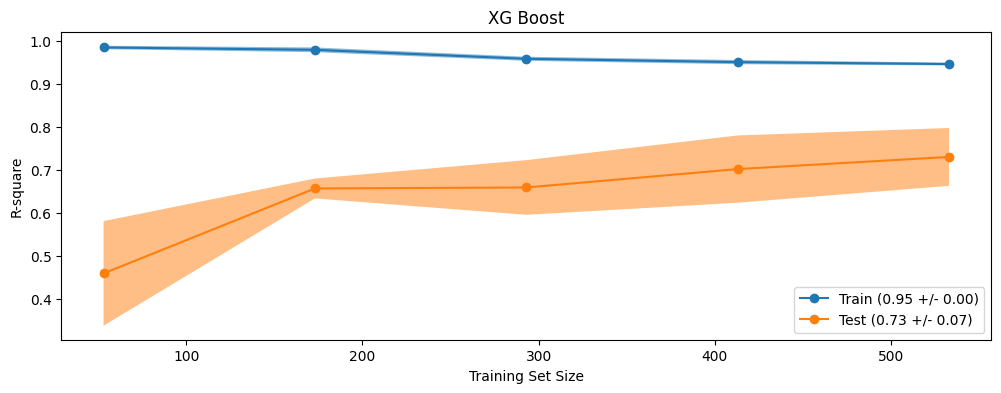

In [39]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

## 6. Model Training

In [40]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [41]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   'additional_info',...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7.Model Evaluation

In [42]:
for name, alg in algorithms.items():
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", alg)
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n{name}:")
    print(f"  R²: {r2:.3f}")
    print(f"  MAE: {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")



Linear Regression:
  R²: 0.708
  MAE: 1630.658
  RMSE: 2182.763

Support Vector Machine:
  R²: 0.007
  MAE: 3274.008
  RMSE: 4027.646

Random Forest:
  R²: 0.709
  MAE: 1350.124
  RMSE: 2181.762

XG Boost:
  R²: 0.691
  MAE: 1359.260
  RMSE: 2248.532


In [43]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [44]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   'additional_info',...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=10, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [45]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.6905946731567383